In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.insert(1,'..')
import numpy as np
import matplotlib.pyplot as plt
from generateFakeData import *
from RmatrixBasedReco import *
from momentBasedReco import *
import qutip as qt

In [4]:
N0 = 2
s = -1 - 2*N0

# Intrinsic Efficiency
eta_intr = 0.5
# Detection efficiency
eta_detection = 1/(1 + N0)
# Total efficiency
eta_total = 1/(1 + N0) * eta_intr

N0_tot = 1/eta_total - 1

print(f'Intrinsic efficency: {eta_intr:.2f}')
print(f'Detection efficency: {eta_detection:.2f}')
print(f'Total efficency: {eta_total:.2f}')
print(f'Total N0: {N0_tot:.2f}')

Intrinsic efficency: 0.50
Detection efficency: 0.33
Total efficency: 0.17
Total N0: 5.00


In [5]:
x_s, p_s = np.linspace(-6, 6, 101), np.linspace(-6, 6, 101)

x, p = np.meshgrid(x_s, p_s, indexing='ij')

sQPD_vac = sQPD_coherent(s, x + 1j*p, 0)
sQPD_fock1 = sQPD_fock(s, x + 1j*p, 1)

### Sampling

In [6]:
N_samples = 100000
batch_size = 10000

# Always samples the vacuum
samples_gnd = sample_from_analytic_distribution(N_samples, f_coherent, (-6, 6, -6, 6), M=1, batch_size=batch_size, s=s, alpha0=0)

samples_sig = sample_from_analytic_distribution(N_samples, f_fock, (-6, 6, -6, 6), M=1, batch_size=batch_size, s=s, n=1)
samples_sig_ineff = np.concatenate([sample_from_analytic_distribution(int(N_samples*eta_intr), f_fock, (-6, 6, -6, 6), M=1, batch_size=batch_size, s=s, n=1), sample_from_analytic_distribution(N_samples - int(N_samples*eta_intr), f_fock, (-6, 6, -6, 6), M=1, batch_size=batch_size, s=s,n=0)])


# Plot checks

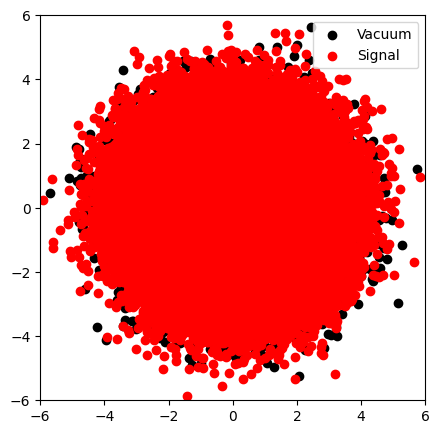

In [7]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(samples_gnd.real, samples_gnd.imag, label='Vacuum', color='black')
ax.scatter(samples_sig.real, samples_sig.imag, label='Signal', color='red')

ax.set_xlim([-6, 6])
ax.set_ylim([-6, 6])
ax.set_aspect('equal')
ax.legend()

# Moments Based Reconstruction (MBR)

In [8]:
# Compute measured moments up to order 5
max_order = 2
measured_moments = calculate_moments(samples_sig, max_order)
measured_ineff_moments = calculate_moments(samples_sig_ineff, max_order)

# Compute noise moments
noise_moments = calculate_moments(samples_gnd, max_order)

sig_moments = extract_a_moments(measured_moments, noise_moments, max_order)
gnd_moments = extract_a_moments(noise_moments, noise_moments, max_order)
sig_ineff_moments = extract_a_moments(measured_ineff_moments, noise_moments, max_order)


# Set max photon number for reconstruction
d = 30

# Reconstruct the density matrix
sig_rec_MBR = build_density_matrix(sig_moments, d, 2*d)
gnd_rec_MBR = build_density_matrix(gnd_moments, d, 2*d)
sig_ineff_rec_MBR = build_density_matrix(sig_ineff_moments, d, 2*d)


Calculating moment of order 2 2 (Max order 2 2)	 Percentage of completion: 100.00%
Calculating moment of order 2 2 (Max order 2 2)	 Percentage of completion: 100.00%
Calculating moment of order 2 2 (Max order 2 2)	 Percentage of completion: 100.00%


# $R \rho R$ reconstruction

In [12]:
d = 30
nbins = 31

counts, alphas = prepare_histograms(np.squeeze(samples_gnd), nbins)
povm_list = [coherent_state_povm(alpha, d) for alpha in alphas]
therm_rec_RrhorR, therm_lik_RrhorR, therm_eig_RrhorR = rhorho_reconstruction(povm_list, counts.flatten(), max_iter=100000, dilution=1e-1, tol=1e-3, improvement_tol=1e-8, patience=100, track_likelihood=True)

KeyboardInterrupt: 

In [ ]:
counts, alphas = prepare_histograms(np.squeeze(samples_sig), nbins)
povm_list = [displaced_povm(alpha, therm_rec_RrhorR) for alpha in alphas]
sig_rec_RrhoR, sig_lik_RrhoR, sig_eig_RrhoR = rhorho_reconstruction(povm_list, counts.flatten(), max_iter=50000, dilution=None, tol=1e-3, improvement_tol=1e-8, patience=100, track_likelihood=True)

Iteration: 19999/20000 Percentage: 34.29% |maxEig(R)-1|: 1.86e-05 > 6.36e-06
Maximum iterations reached without full convergence.


In [ ]:
counts, alphas = prepare_histograms(np.squeeze(samples_sig_ineff), nbins)
povm_list = [displaced_povm(alpha, therm_rec_RrhorR) for alpha in alphas]
sig_ineff_rec_RrhoR, sig_ineff_lik_RrhoR, sig_ineff_eig_RrhoR = rhorho_reconstruction(povm_list, counts.flatten(), max_iter=50000, dilution=None, tol=1e-3, improvement_tol=1e-8, patience=100, track_likelihood=True)

Iteration: 9999/10000 Percentage: 21.23% |maxEig(R)-1|: 3.00e-05 > 6.36e-06
Maximum iterations reached without full convergence.


# Plots

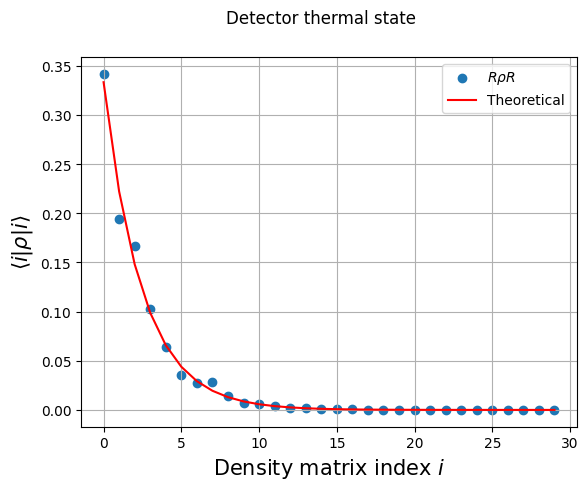

In [10]:
fig, ax = plt.subplots()
fig.suptitle('Detector thermal state')
ax.scatter(np.arange(0,d),np.diagonal(np.abs(therm_rec_RrhorR)), label='$R \\rho R$')
ax.plot(np.arange(0,d), np.diagonal(np.abs(qt.thermal_dm(d, N0).full())), color='red', label='Theoretical')
ax.set_xlabel('Density matrix index $i$', fontsize=15)
ax.set_ylabel('$\\langle i|\\rho|i \\rangle$', fontsize=15)
ax.grid()
ax.legend()

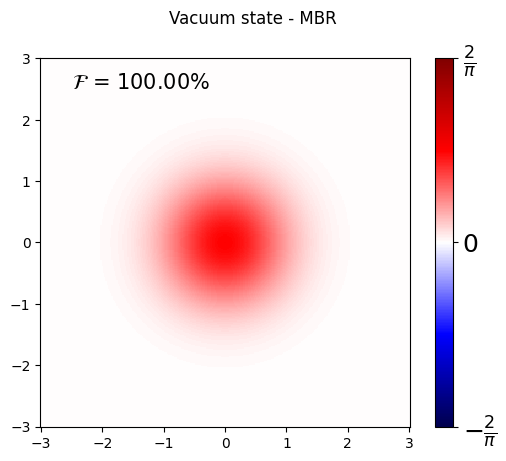

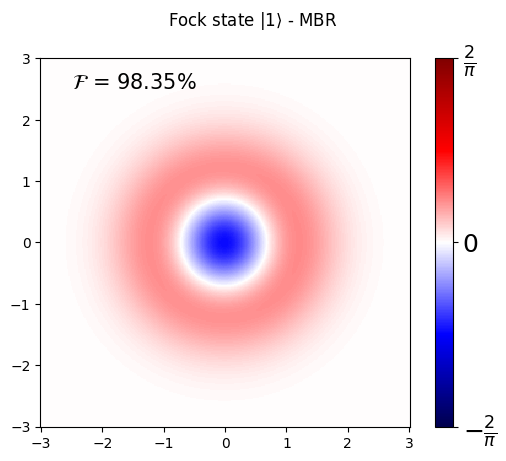

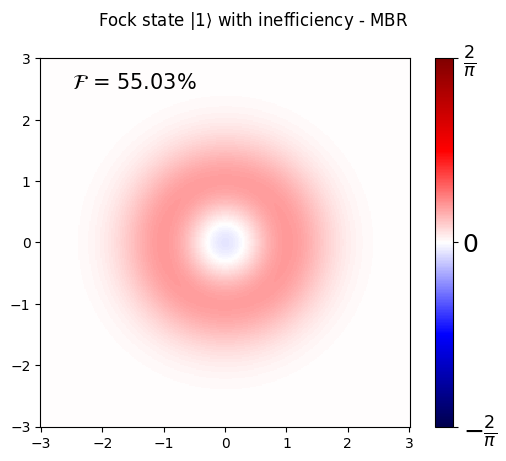

In [56]:
x_s, p_s = np.linspace(-3,3,301), np.linspace(-3,3,301)

fig, ax = plt.subplots()
fig.suptitle('Vacuum state - MBR')
cm = ax.pcolormesh(x_s, p_s, qt.wigner(qt.Qobj(gnd_rec_MBR), x_s, p_s), cmap='seismic', vmax=2/np.pi, vmin=-2/np.pi)
cb = plt.colorbar(cm, ax=ax)
cb.ax.tick_params('both', labelsize=18)
cb.set_ticks([-2/np.pi, 0, 2/np.pi])
cb.set_ticklabels(['$-\\frac{2}{\\pi}$', '0', '$\\frac{2}{\\pi}$'])
ax.text(-2.5,2.5,'$\\mathcal{F}$ = ' + f'{100*qt.fidelity(qt.Qobj(gnd_rec_MBR), qt.fock_dm(d,0))**2:.2f}%', fontsize=15)
ax.set_aspect('equal', adjustable='box')

fig, ax = plt.subplots()
fig.suptitle('Fock state $|1 \\rangle$ - MBR')
cm = ax.pcolormesh(x_s, p_s, qt.wigner(qt.Qobj(sig_rec_MBR), x_s, p_s), cmap='seismic', vmax=2/np.pi, vmin=-2/np.pi)
cb = plt.colorbar(cm, ax=ax)
cb.ax.tick_params('both', labelsize=18)
cb.set_ticks([-2/np.pi, 0, 2/np.pi])
cb.set_ticklabels(['$-\\frac{2}{\\pi}$', '0', '$\\frac{2}{\\pi}$'])
ax.text(-2.5,2.5,'$\\mathcal{F}$ = ' + f'{100*qt.fidelity(qt.Qobj(sig_rec_MBR), qt.fock_dm(d,1))**2:.2f}%', fontsize=15)
ax.set_aspect('equal', adjustable='box')


fig, ax = plt.subplots()
fig.suptitle('Fock state $|1 \\rangle$ with inefficiency - MBR')
cm = ax.pcolormesh(x_s, p_s, qt.wigner(qt.Qobj(sig_ineff_rec_MBR), x_s, p_s), cmap='seismic', vmax=2/np.pi, vmin=-2/np.pi)
cb = plt.colorbar(cm, ax=ax)
cb.ax.tick_params('both', labelsize=18)
cb.set_ticks([-2/np.pi, 0, 2/np.pi])
cb.set_ticklabels(['$-\\frac{2}{\\pi}$', '0', '$\\frac{2}{\\pi}$'])
ax.text(-2.5,2.5,'$\\mathcal{F}$ = ' + f'{100*qt.fidelity(qt.Qobj(sig_ineff_rec_MBR), qt.fock_dm(d,1))**2:.2f}%', fontsize=15)
ax.set_aspect('equal', adjustable='box')

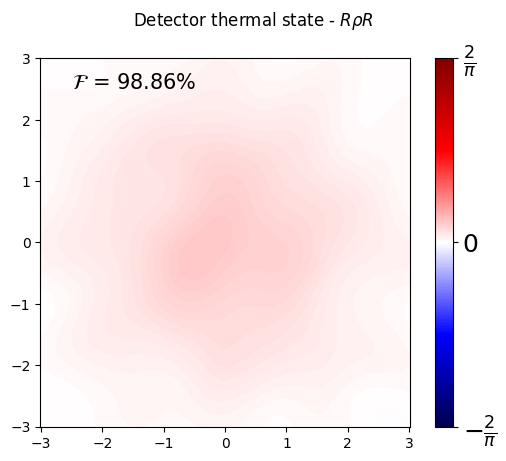

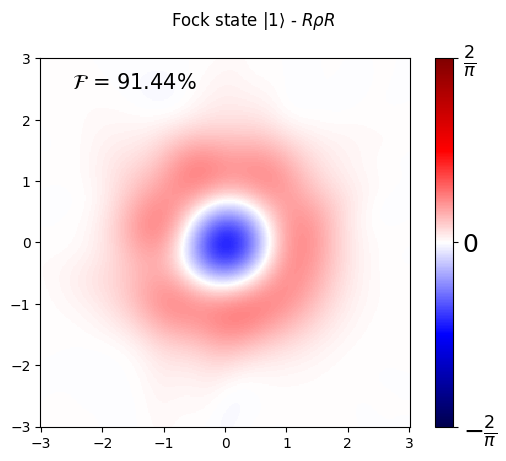

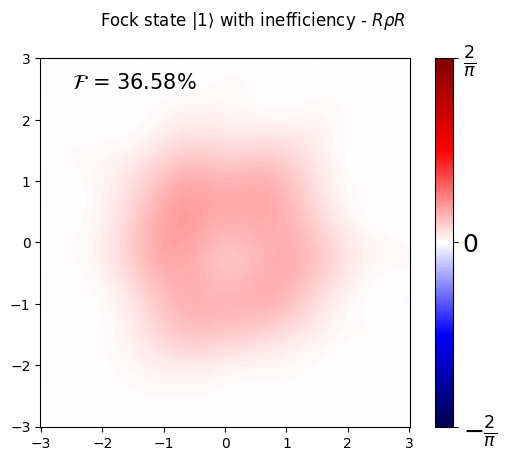

In [ ]:
x_s, p_s = np.linspace(-3,3,301), np.linspace(-3,3,301)

fig, ax = plt.subplots()
fig.suptitle('Detector thermal state - $R \\rho R$')
cm = ax.pcolormesh(x_s, p_s, qt.wigner(qt.Qobj(therm_rec_RrhorR), x_s, p_s), cmap='seismic', vmax=2/np.pi, vmin=-2/np.pi)
cb = plt.colorbar(cm, ax=ax)
cb.ax.tick_params('both', labelsize=18)
cb.set_ticks([-2/np.pi, 0, 2/np.pi])
cb.set_ticklabels(['$-\\frac{2}{\\pi}$', '0', '$\\frac{2}{\\pi}$'])
ax.text(-2.5,2.5,'$\\mathcal{F}$ = ' + f'{100*qt.fidelity(qt.Qobj(therm_rec_RrhorR), qt.thermal_dm(d,N0))**2:.2f}%', fontsize=15)
ax.set_aspect('equal', adjustable='box')

fig, ax = plt.subplots()
fig.suptitle('Fock state $|1 \\rangle$ - $R \\rho R$')
cm = ax.pcolormesh(x_s, p_s, qt.wigner(qt.Qobj(sig_rec_RrhoR), x_s, p_s), cmap='seismic', vmax=2/np.pi, vmin=-2/np.pi)
cb = plt.colorbar(cm, ax=ax)
cb.ax.tick_params('both', labelsize=18)
cb.set_ticks([-2/np.pi, 0, 2/np.pi])
cb.set_ticklabels(['$-\\frac{2}{\\pi}$', '0', '$\\frac{2}{\\pi}$'])
ax.text(-2.5,2.5,'$\\mathcal{F}$ = ' + f'{100*qt.fidelity(qt.Qobj(sig_rec_RrhoR), qt.fock_dm(d,1))**2:.2f}%', fontsize=15)
ax.set_aspect('equal', adjustable='box')


fig, ax = plt.subplots()
fig.suptitle('Fock state $|1 \\rangle$ with inefficiency - $R \\rho R$')
cm = ax.pcolormesh(x_s, p_s, qt.wigner(qt.Qobj(sig_ineff_rec_RrhoR), x_s, p_s), cmap='seismic', vmax=2/np.pi, vmin=-2/np.pi)
cb = plt.colorbar(cm, ax=ax)
cb.ax.tick_params('both', labelsize=18)
cb.set_ticks([-2/np.pi, 0, 2/np.pi])
cb.set_ticklabels(['$-\\frac{2}{\\pi}$', '0', '$\\frac{2}{\\pi}$'])
ax.text(-2.5,2.5,'$\\mathcal{F}$ = ' + f'{100*qt.fidelity(qt.Qobj(sig_ineff_rec_RrhoR), qt.fock_dm(d,1))**2:.2f}%', fontsize=15)
ax.set_aspect('equal', adjustable='box')
